# Model-asisted Labeling with YOLOv5
> bootstrapping image annotation

![base64 splash](https://github.com/PhilBrockman/ModelAssistedLabel/blob/master/modelassistedlabel%20splash.jpg?raw=true)

## Background

Object detection is great! ... if your labeled dataset already exists. I wanted to use machine learning to turn my regular rowing machine into a "smart" rowing machine (specifically: I want to track my workout stats).

Unfortunately, I was unable to find a suitable existing set of labeled LCD digits. So I began using my webcam to campture images of my rowing screen.

After working through [a YOLOv5 tutorial]( https://models.roboflow.com/object-detection/yolov5), I started to use Roboflow to annotate and store my images. But I hated annotating my images by hand. Once the models began making reasonable guesses, I enlisted the model's help in labeling new images. This repository is the result of these efforts.

(Later on, I developed a [custom React annotator](https://github.com/PhilBrockman/autobbox) as a curiousity. However, I labeled dozens upon dozens of images with Roboflow and would recommend their free annotation service.)

## Getting Started

> Tip: [Open In Colab](https://colab.research.google.com/github/PhilBrockman/ModelAssistedLabel/blob/master/index.ipynb)

In [ ]:
# clone this repository
!git clone https://github.com/PhilBrockman/ModelAssistedLabel.git
%cd "ModelAssistedLabel"

### Expected Inputs:
* Both 
  - **labeled images**
      + All of the images and labels must be in a common folder (subfolders allowed).
      + labels must be in [YOLOv5 format](https://github.com/AlexeyAB/Yolo_mark/issues/60#issuecomment-401854885).

      > Note: Image/label pairs are based on their base filename. For example `image.jpg/image.txt` would be paired as would `other_image5.jpg/other_image5.txt`.
      + I provide 841 annotated images in the github.

* And:
  - **unlabeled images**
      + I provide 3 sets (each of 200 images) in the github





In [ ]:
# these images have already had the images labeled and verified by a human
labeled_images   = "Image Repo/labeled/Final Roboflow Export (841)"

# one of the sets of unlabeled images
unlabeled_images = "21-3-22 rowing (200) 7:50-12:50"

### Expected Output:

* **Folder** that contains: 
    - `images/`
      + a copy of every image in **Unlabeled Data**
    - `labels/`
      + result of running object detection on each image
    - a results folder produced by Ultralytic's `train.py` on the **Labeled Data** (if not using pre-trained weights)
    - `class labels.txt` to preserve the identity of the classes


In [ ]:
project_name = "seven segment digits"
export_folder = Defaults._itername(project_name)
os.mkdir(export_folder)
print(export_folder)

seven segment digits1


## Configure defaults

Several values are stored by the `Defaults` class. Any value can be overridden (and new values can be added. Make sure to `save()` any changes!

In [ ]:
d = Defaults()
print(" -- Defined Keys: --")
print("\n".join([x for x in d.__dict__.keys()]))

 -- Defined Keys: --
config_file
root
split_ratio
data_yaml
resource_map
trainer_template


Speciy the absolute path of the root directory.

In [ ]:
!pwd

/content/ModelAssistedLabel


In [ ]:
d.root = "/content/ModelAssistedLabel/"

Save any changes and enter root directory

In [ ]:
d.save()
d.to_root()

These following 14 lines regarding seting up the Ultralytics are taken from [the Roboflow tutorial]( https://models.roboflow.com/object-detection/yolov5).

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else raise Exception("enable GPU")))

Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
d.to_root() 

moving to /content/drive/MyDrive/Coding/ModelAssistedLabel/


## Processing input

Next, the images need to be written in a way so that the Ultralytics repository can understand their content. The `Autoweights` class both organizes data and create weights. Running an "initialize" command makes changes to the disk.

In [ ]:
from ModelAssistedLabel.train import AutoWeights

datadump="ipynb_tests/index"

aw = AutoWeights(name="<index>", out_dir=datadump, MAX_SIZE=200)
aw.initialize_images_from_bag(labeled_images)
aw.traverse_resources()


dirs ['./train', './valid', './test']
yaml ipynb_tests/index/Final Roboflow Export (841)<index> 21-03-25 12-30-41/data.yaml
subdir train
	outdir ipynb_tests/index/Final Roboflow Export (841)<index> 21-03-25 12-30-41
subdir valid
	outdir ipynb_tests/index/Final Roboflow Export (841)<index> 21-03-25 12-30-41
subdir test
	outdir ipynb_tests/index/Final Roboflow Export (841)<index> 21-03-25 12-30-41
os.listdir ['train', 'valid', 'test', 'data.yaml']
train/images
	 > 140 files
train/labels
	 > 140 files
valid/images
	 > 40 files
valid/labels
	 > 40 files
test/images
	 > 20 files
test/labels
	 > 20 files
File:  data.yaml


## Generate Weights

With the images written to disk, we can run the Ultralytics training algorithm. On this dataset, I found 1200 epochs to be a reasonable stopping point but using even longer training times are not uncommon.

In [ ]:
%%time
aw.generate_weights(1000)

CPU times: user 10.5 s, sys: 1.45 s, total: 11.9 s
Wall time: 45min 23s


'yolov5/runs/train/<index>'

The results folder is stored as an attribute as well, and it has a lot of data stored therein.

In [ ]:
import os
aw.last_results_path, len(os.listdir(aw.last_results_path))

('yolov5/runs/train/<index>', 20)

However, the weights are stored in a subfolder called (aptly) "weights". I use `best.pt`.

In [ ]:
os.listdir(aw.last_results_path + "/weights")

['last.pt', 'best.pt']

View the last couple lines 

In [ ]:
with open(aw.last_results_path + "/results.txt") as results_file:
  results = results_file.readlines()
print("Epoch   gpu_mem       box       obj       cls     total    labels  img_size")
results[-5:]

Epoch   gpu_mem       box       obj       cls     total    labels  img_size


['   995/999     1.82G   0.02979   0.02355   0.01262   0.06595       119       416    0.9787    0.9698    0.9861    0.8327   0.02502   0.01936  0.008843\n',
 '   996/999     1.82G   0.02952   0.02375   0.01236   0.06562       124       416    0.9785    0.9677    0.9861    0.8326   0.02496   0.01922  0.008919\n',
 '   997/999     1.82G   0.03078   0.02463   0.01184   0.06725       162       416    0.9719    0.9679    0.9859    0.8301   0.02492   0.01924  0.008982\n',
 '   998/999     1.82G   0.03055   0.02504   0.01201    0.0676       148       416     0.973    0.9663    0.9859    0.8312   0.02488   0.01942   0.00898\n',
 '   999/999     1.82G   0.03112   0.02214   0.01227   0.06553       146       416    0.9731    0.9666    0.9857    0.8301   0.02482   0.01951  0.009014\n']

## Labeling a new set of images

Training a model from scratch on every run would be too inefficient. Instead, I load models from their saved weights.

In [ ]:
res_folder = 'yolov5/runs/train/<index>' # "this is a result I cooked up earlier"
pretrained =  res_folder + "/weights/best.pt"

The names of my classes are digits. Under the hood, the YOLOv5 model is working of the index of the class, rather than the human-readable name. Consequently, the identities of each class index must be supplied as a `str`.

In [ ]:
class_idx = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

The `Viewer` class handles making predictions and making predictions in a visible way.

In [ ]:
from ModelAssistedLabel.detect import Viewer

v = Viewer(pretrained, class_idx)

Fusing layers... 


Grab all ".jpg" files from a specified directory

In [ ]:
!ls "Image Repo/unlabeled"

'21-3-18 rowing 8-12 '		  '21-3-22 rowing (200) 7:50-12:50'
'21-3-22 rowing (200) 1:53-7:00'


In [ ]:
unlabeled_images = './Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50'

In [ ]:
import random, glob

images = [x for x in glob.glob(f"{unlabeled_images}/*.jpg")]
len(images)

200

Let's see how the model is doing

image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/13.jpg: >>> [{'predictions': ['9 0.364844 0.370833 0.021875 0.0833333 0.525065', '0 0.415234 0.377083 0.0148437 0.0736111 0.615838', '7 0.389453 0.375694 0.0210938 0.0819444 0.704021', '9 0.435156 0.383333 0.0234375 0.0777778 0.837819']}]


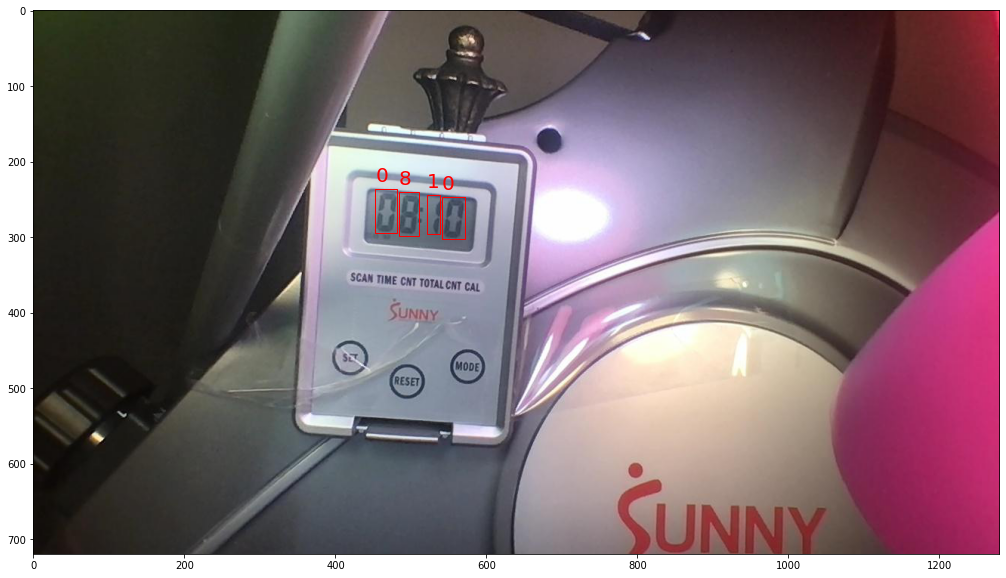

image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/103.jpg: >>> [{'predictions': ['9 0.387891 0.377778 0.0210938 0.0722222 0.660994', '0 0.373047 0.374306 0.0164062 0.0763889 0.733751', '7 0.436328 0.382639 0.0226563 0.0819444 0.742332']}]


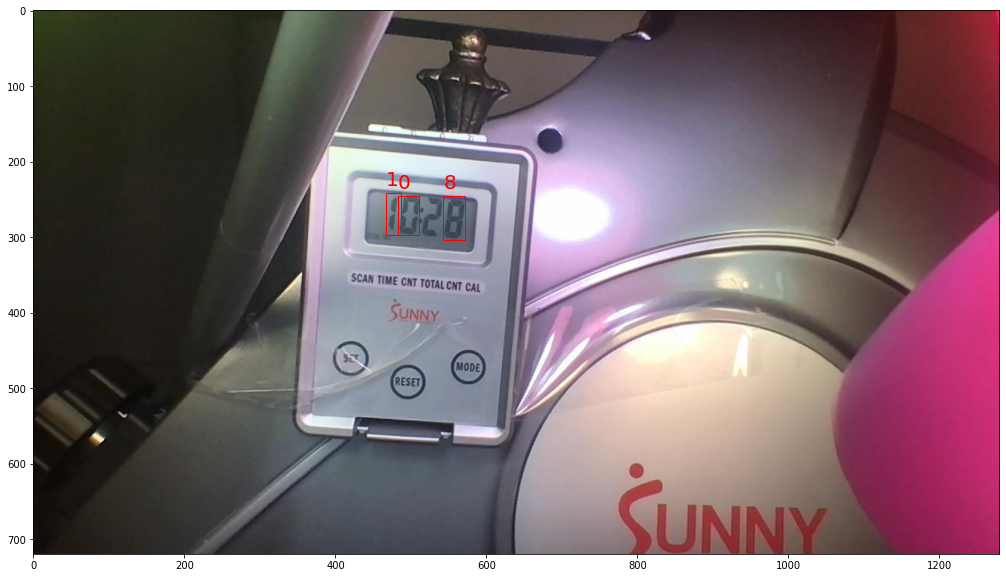

image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/137.jpg: >>> [{'predictions': ['3 0.403906 0.377778 0.0265625 0.0722222 0.454449', '0 0.373437 0.375 0.015625 0.075 0.892345', '9 0.4375 0.384028 0.021875 0.0763889 0.914681']}]


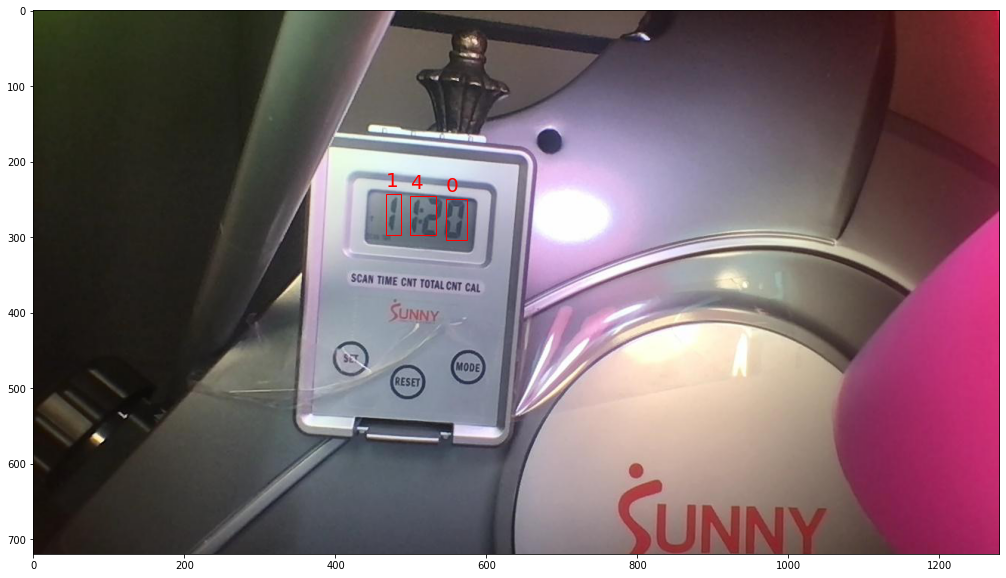

In [ ]:
%matplotlib inline 
for image in random.sample(images,3):
  v.plot_for(image)

In [ ]:
results = []
for image in images:
  results.append(v.predict_for(image))

image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/177.jpg: >>> [{'predictions': ['0 0.367578 0.38125 0.0195312 0.0736111 0.500232', '1 0.411328 0.382639 0.0210938 0.0791667 0.674695']}]
image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/185.jpg: >>> [{'predictions': ['0 0.369531 0.368056 0.0171875 0.0777778 0.466282', '1 0.390234 0.369444 0.0210938 0.0777778 0.582081', '2 0.413281 0.367361 0.01875 0.0791667 0.602832', '4 0.435937 0.373611 0.0203125 0.0777778 0.717384']}]
image 1/1 /content/drive/My Drive/Coding/ModelAssistedLabel/Image Repo/unlabeled/21-3-22 rowing (200) 7:50-12:50/184.jpg: >>> [{'predictions': ['4 0.435547 0.372917 0.0195312 0.0763889 0.462318', '0 0.369141 0.36875 0.0179687 0.0763889 0.530017', '1 0.390234 0.370139 0.0210938 0.0791667 0.549572', '2 0.413672 0.368056 0.0179687 0.0777778 0.670889']}]
image 1/1 /content/drive/My Drive/Coding/Model

## Exporting annotated images

Store the class labels with index 0 on line 1, index 1 on line 2, and so on.

In [ ]:
with open(os.path.join(export_folder, "label_map.txt"), "w") as label_map:
  label_map.writelines("\n".join(class_idx))

Ensure that image/label pairs have a common root filename

In [ ]:
import random, PIL, shutil
salt = lambda: str(random.random())[2:]

for result in results:
  #generate a likely-to-be-unique filename
  shared_root = Defaults._itername(f"{project_name}-{salt()}")

  #save the image to the outfile
  image = PIL.Image.open(result["image path"])
  image.save(os.path.join(export_folder, "images", f"{shared_root}.jpg"))

  #save the predictions to the outfile
  predictions = result["predictions"]
  with open(os.path.join(export_folder, "labels", f"{shared_root}.txt"), "w") as prediction_file:
    prediction_file.writelines("\n".join([x["yolov5 format"] for x in predictions]))

  #check if weights were generated
  if aw is not None and os.path.exists(aw.last_results_path):
    print("Moving yolov5 results folder")
    shutil.move(aw.last_results_path, export_folder)
  else:
    print("No weights to save")

In [ ]:
len(os.listdir(export_folder))

## Next Steps





